## COBA 8 KELAS ##

In [ ]:
%pip install boruta
%pip install imblearn
%pip install shap
%pip install optuna
%pip install optuna-integration[sklearn]

!pip install lightgbm
!pip install --upgrade imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import time
import lightgbm as lgb
import psutil
import shap
import gc  # Garbage collector untuk clear memory
import optuna
from optuna.integration import OptunaSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**BAGIAN 1: PREPROCESSING DATA**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/merged_dataset_saya_setelah_rename.csv')

Cleaning Data

In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # hanya tampilkan kolom yang ada null-nya

Std         25
Variance    25
dtype: int64


In [ ]:
df = df.dropna() #Hapus 25 baris

Cleaning Infinity & NaN

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        if pd.isna(median_val):
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna(median_val, inplace=True)

Cek Duplicate Value

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")

Jumlah baris duplikat: 83381


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (744252, 41)


Label Encoding

In [ ]:
#Inisialisasi Encoder
le = LabelEncoder()

# Fit dan transform label
df['Label_encoded'] = le.fit_transform(df['label'])

In [ ]:
# Display the first few rows of the dataframe with the new column
display(df.head())

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label,Label_encoded
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.0,0.00,0.0,...,578,563.26,84.239991,563.26,0.000251,100,7096.376162,Mirai,Mirai_Greip_Flood,24
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.0,0.00,0.0,...,578,573.20,48.000000,573.20,0.000195,100,2304.000000,Mirai,Mirai_Greip_Flood,24
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578.00,0.000000,578.00,0.000363,100,0.000000,Mirai,Mirai_Greip_Flood,24
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578.00,0.000000,578.00,0.000074,100,0.000000,Mirai,Mirai_Greip_Flood,24
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.0,0.01,0.0,...,590,563.09,75.596763,563.09,0.000408,100,5714.870606,Mirai,Mirai_Greip_Flood,24


In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label -> Angka:")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

Mapping Label -> Angka:
Backdoor_Malware -> 0
Benign_Traffic -> 1
Browser_Hijacking -> 2
Command_Injection -> 3
DDoS_ACK_Fragmentation -> 4
DDoS_HTTP_Flood -> 5
DDoS_ICMP_Flood -> 6
DDoS_ICMP_Fragmentation -> 7
DDoS_PSHACK_Flood -> 8
DDoS_RSTFIN_Flood -> 9
DDoS_SYN_Flood -> 10
DDoS_SlowLoris -> 11
DDoS_SynonymousIP_Flood -> 12
DDoS_TCP_Flood -> 13
DDoS_UDP_Flood -> 14
DDoS_UDP_Fragmentation -> 15
DNS_Spoofing -> 16
Dictionary_Brute_Force -> 17
DoS_HTTP_Flood -> 18
DoS_SYN_Flood -> 19
DoS_TCP_Flood -> 20
DoS_UDP_Flood -> 21
MITM_Arp_Spoofing -> 22
Mirai_Greeth_Flood -> 23
Mirai_Greip_Flood -> 24
Mirai_UDPPlain -> 25
Recon_Host_Discovery -> 26
Recon_OSScan -> 27
Recon_Ping_Sweep -> 28
Recon_Port_Scan -> 29
Recon_Vulnerability_Scan -> 30
SQL_Injection -> 31
Uploading_Attack -> 32
XSS -> 33


In [ ]:
# 1. Definisikan pemetaan dari 34 kelas ke 8 kategori
mapping_kategori = {
    # Benign
    'Benign_Traffic': 'Benign',

    # DDoS
    'DDoS_ACK_Fragmentation': 'DDoS',
    'DDoS_UDP_Flood': 'DDoS',
    'DDoS_SlowLoris': 'DDoS',
    'DDoS_ICMP_Flood': 'DDoS',
    'DDoS_RSTFIN_Flood': 'DDoS',
    'DDoS_PSHACK_Flood': 'DDoS',
    'DDoS_HTTP_Flood': 'DDoS',
    'DDoS_UDP_Fragmentation': 'DDoS',
    'DDoS_TCP_Flood': 'DDoS',
    'DDoS_SYN_Flood': 'DDoS',
    'DDoS_SynonymousIP_Flood': 'DDoS',
    'DDoS_ICMP_Fragmentation': 'DDoS',

    # Brute Force
    'Dictionary_Brute_Force': 'Brute Force',

    # Spoofing
    'MITM_Arp_Spoofing': 'Spoofing',
    'DNS_Spoofing': 'Spoofing',

    # DoS
    'DoS_TCP_Flood': 'DoS',
    'DoS_HTTP_Flood': 'DoS',
    'DoS_SYN_Flood': 'DoS',
    'DoS_UDP_Flood': 'DoS',

    # Recon
    'Recon_Ping_Sweep': 'Recon',
    'Recon_OSScan': 'Recon',
    'Recon_Vulnerability_Scan': 'Recon',
    'Recon_Port_Scan': 'Recon',
    'Recon_Host_Discovery': 'Recon',

    # Web-based
    'SQL_Injection': 'Web-Based',
    'Command_Injection': 'Web-Based',
    'Backdoor_Malware': 'Web-Based',
    'Uploading_Attack': 'Web-Based',
    'XSS': 'Web-Based',
    'Browser_Hijacking': 'Web-Based',

    # Mirai
    'Mirai_Greip_Flood': 'Mirai',
    'Mirai_Greeth_Flood': 'Mirai',
    'Mirai_UDPPlain': 'Mirai'
}

# 2. Buat kolom baru di DataFrame menggunakan pemetaan ini
df['category_8_class'] = df['label'].map(mapping_kategori)

# 3. (Opsional tapi sangat disarankan) Verifikasi hasilnya
print("Distribusi 8 Kategori Baru:")
print(df['category_8_class'].value_counts())

Distribusi 8 Kategori Baru:
category_8_class
DDoS           296754
Recon          137094
DoS            114146
Spoofing        63790
Mirai           60686
Benign          33987
Web-Based       24733
Brute Force     13062
Name: count, dtype: int64


Memisahkan Fitur & Label

In [ ]:
X = df.drop(["label", "category", "Label_encoded", "category_8_class"], axis=1)
y = df["category_8_class"]

Split Data

In [ ]:
# Split 1: Train vs (Val+Test) - 70% vs 30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,      # 30% untuk val+test
    stratify=y,         # Stratified untuk jaga proporsi kelas dan PENTING untuk imbalanced data
    random_state=42
)

# Split 2: Val vs Test - 15% vs 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% dari 30% = 15% dari total
    stratify=y_temp,
    random_state=42
)

print(f" Data split complete!")
print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Val:   {X_val.shape[0]:,} samples")
print(f"   Test:  {X_test.shape[0]:,} samples")

 Data split complete!
   Train: 520,976 samples
   Val:   111,638 samples
   Test:  111,638 samples


Seleksi Fitur Tahap Awal

In [ ]:
# Cek fitur dengan 1 nilai unik
constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
print("Fitur konstan:", constant_columns)

Fitur konstan: []


In [ ]:
# Hapus jika ada dari semua set data
if constant_columns:
    X_train.drop(columns=constant_columns, inplace=True)
    print(f"Fitur konstan {constant_columns} dihapus dari X_train_res.")
else:
    print("Tidak ada fitur konstan yang ditemukan.")

Tidak ada fitur konstan yang ditemukan.


In [ ]:
# Hitung korelasi
corr_matrix = X_train.corr().abs()

# Ambil korelasi di atas threshold (misal 0.98)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

print("Fitur berkorelasi tinggi:", to_drop)

Fitur berkorelasi tinggi: ['fin_count', 'IPv', 'LLC', 'Tot size']


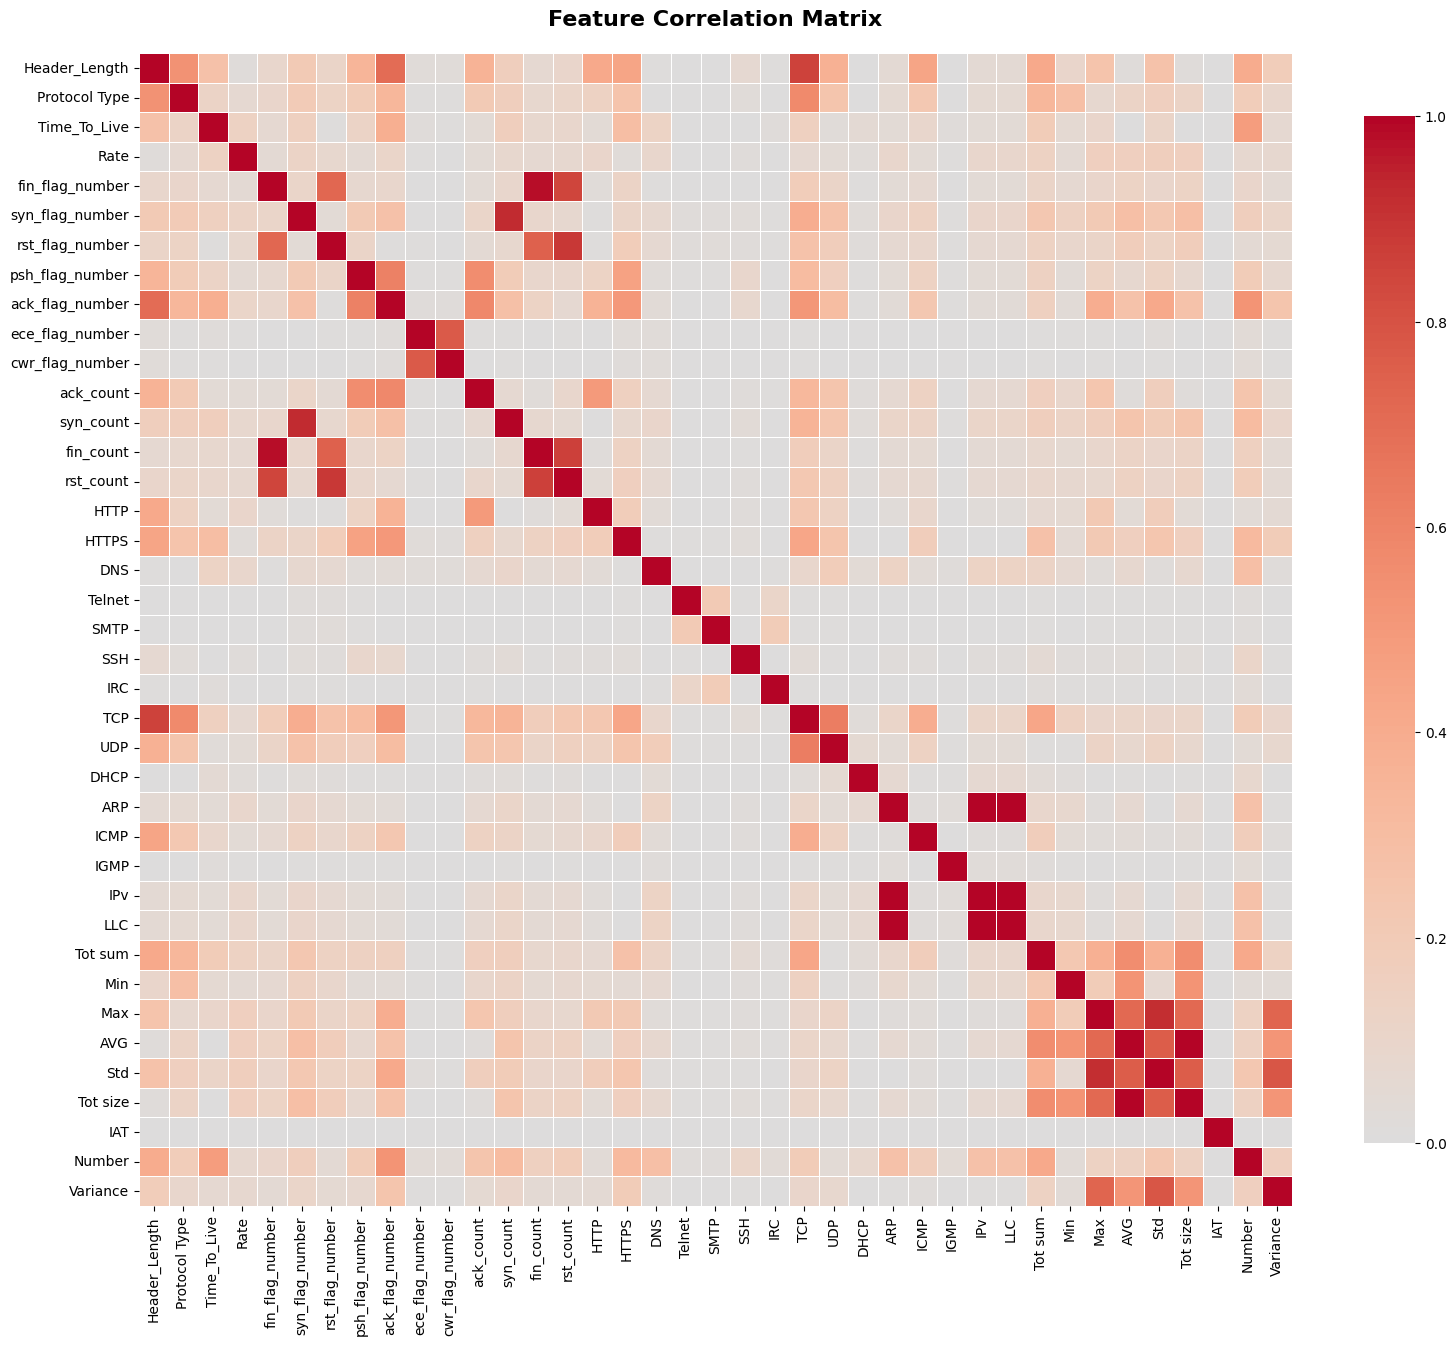

In [ ]:
# Visualisasi Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=False,  # Set True jika fitur sedikit (<20)
    cmap='coolwarm',
    center=0,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Find High Correlation Pairs
def find_high_correlation_pairs(corr_matrix, threshold=0.95):
    """
    Menemukan pasangan fitur dengan korelasi tinggi
    """
    # Ambil upper triangle (avoid duplicates)
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find pairs above threshold
    high_corr_pairs = []

    for column in upper_tri.columns:
        high_corr_features = upper_tri[column][upper_tri[column] > threshold]

        for feature, corr_value in high_corr_features.items():
            high_corr_pairs.append({
                'Feature_1': column,
                'Feature_2': feature,
                'Correlation': corr_value
            })

    # Convert to DataFrame and sort
    df_pairs = pd.DataFrame(high_corr_pairs).sort_values(
        'Correlation', ascending=False
    )

    return df_pairs

In [ ]:
# Cari pasangan dengan korelasi > 0.95
threshold = 0.95
high_corr_df = find_high_correlation_pairs(corr_matrix, threshold)

print(f"HIGH CORRELATION PAIRS (threshold > {threshold})")

if len(high_corr_df) > 0:
    print(f"\n Found {len(high_corr_df)} pairs with correlation > {threshold}:\n")
    print(high_corr_df.to_string(index=False))

    # Summary statistics
    print(f"\n Correlation Statistics:")
    print(f"   Highest correlation: {high_corr_df['Correlation'].max():.4f}")
    print(f"   Average correlation: {high_corr_df['Correlation'].mean():.4f}")
    print(f"   Lowest (above threshold): {high_corr_df['Correlation'].min():.4f}")
else:
    print(f"\n No pairs found with correlation > {threshold}")

HIGH CORRELATION PAIRS (threshold > 0.95)

 Found 5 pairs with correlation > 0.95:

Feature_1       Feature_2  Correlation
      IPv             ARP     1.000000
      LLC             ARP     1.000000
      LLC             IPv     1.000000
 Tot size             AVG     1.000000
fin_count fin_flag_number     0.982054

 Correlation Statistics:
   Highest correlation: 1.0000
   Average correlation: 0.9964
   Lowest (above threshold): 0.9821


In [ ]:
print(f" Menghapus {len(to_drop)} Fitur Mirip/Korelasi Tinggi")

X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

 Menghapus 4 Fitur Mirip/Korelasi Tinggi


In [ ]:
if to_drop:
    print(f" Dropped {len(to_drop)} features")
    print(f" Remaining features: {X_train.shape[1]}")
else:
    print("\n No highly correlated features found")

 Dropped 4 features
 Remaining features: 35


Cleaning infinity & NaN Lagi

In [ ]:
print("Final cleaning before Boruta...")
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    if X_train[col].isnull().any():
        median_val = X_train[col].median()
        if pd.isna(median_val):
            X_train[col].fillna(0, inplace=True)
            X_val[col].fillna(0, inplace=True)
            X_test[col].fillna(0, inplace=True)
        else:
            X_train[col].fillna(median_val, inplace=True)
            X_val[col].fillna(median_val, inplace=True)
            X_test[col].fillna(median_val, inplace=True)

Final cleaning before Boruta...


In [ ]:
# Verify data is clean
print(" Verification:")
print(f"   Train - Inf: {np.isinf(X_train.values).any()}, NaN: {X_train.isnull().values.any()}")
print(f"   Val   - Inf: {np.isinf(X_val.values).any()}, NaN: {X_val.isnull().values.any()}")
print(f"   Test  - Inf: {np.isinf(X_test.values).any()}, NaN: {X_test.isnull().values.any()}")

 Verification:
   Train - Inf: False, NaN: False
   Val   - Inf: False, NaN: False
   Test  - Inf: False, NaN: False


Seleksi Fitur dengan Boruta

In [ ]:
# Random Forest dengan parameter balanced
rf = RandomForestClassifier(
    n_estimators=100,      # Cukup untuk stability
    max_depth=15,          # Cukup dalam untuk 34/8 kelas
    min_samples_split=10,  # Prevent overfitting
    min_samples_leaf=4,    # Prevent overfitting
    max_features='sqrt',   # Good default untuk classification
    class_weight='balanced',  # Penting untuk imbalanced
    n_jobs=-1,             # Use all cores
    random_state=42,
    bootstrap=True,
    oob_score=False,       # Save memory
    verbose=0
)

In [ ]:
# Boruta dengan parameter optimal
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # Auto-determine iterations
    max_iter=100,          # Maximum iterations
    verbose=2,             # Show progress
    random_state=42,
    perc=100,              # Percentile for importance threshold
    alpha=0.05             # Statistical significance level
)

In [ ]:
    print(f" Dataset Info:")
    print(f"   Samples: {X_train.shape[0]:,}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Classes: {len(np.unique(y_train))}")

    print(f"\n Random Forest Config:")
    print(f"   n_estimators: {rf.n_estimators}")
    print(f"   max_depth: {rf.max_depth}")
    print(f"   max_features: {rf.max_features}")
    print(f"   class_weight: {rf.class_weight}")

    print(f"\n Boruta Config:")
    print(f"   max_iter: {boruta.max_iter}")
    print(f"   alpha: {boruta.alpha}")

    print(f"\n Estimasi waktu: 15-30 menit")

 Dataset Info:
   Samples: 520,976
   Features: 35
   Classes: 8

 Random Forest Config:
   n_estimators: 100
   max_depth: 15
   max_features: sqrt
   class_weight: balanced

 Boruta Config:
   max_iter: 100
   alpha: 0.05

 Estimasi waktu: 15-30 menit


In [ ]:
# Fit Boruta Hanya di Train Set
start_time = time.time()

boruta.fit(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n Boruta completed in {elapsed_time/60:.1f} minutes")

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	27
Tentative: 	1
Rejected: 	7
I

In [ ]:
#Simpan hasil Boruta
joblib.dump(boruta, "/content/drive/MyDrive/Dataset/Percobaan_Enam/boruta_model.pkl")

#Simpan daftar fitur terpilih
np.save("/content/drive/MyDrive/Dataset/Percobaan_Enam/selected_features.npy", selected_features)

In [ ]:
#Load hasil Boruta
boruta = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/boruta_model.pkl")

#Load daftar fitur terpilih
selected_features = np.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/selected_features.npy", allow_pickle=True).tolist()

print("Model Boruta dan fitur terpilih berhasil di-load kembali.")
print("Fitur terpilih:", selected_features)

Model Boruta dan fitur terpilih berhasil di-load kembali.
Fitur terpilih: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'UDP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
# Mendapatkan Fitur Terpilih Boruta
selected_features = X_train.columns[boruta.support_].tolist() if isinstance(X_train, pd.DataFrame) else boruta.support_
rejected_features = X_train.columns[~boruta.support_].tolist() if isinstance(X_train, pd.DataFrame) else ~boruta.support_

print(f" Results:")
print(f"   Selected features: {len(selected_features) if isinstance(selected_features, list) else selected_features.sum()}")
print(f"   Rejected features: {len(rejected_features) if isinstance(rejected_features, list) else rejected_features.sum()}")
print(f"   Selection rate: {100 * boruta.support_.sum() / len(boruta.support_):.1f}%")

 Results:
   Selected features: 28
   Rejected features: 7
   Selection rate: 80.0%


In [ ]:
print(f" SELECTED FEATURES ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n REJECTED FEATURES ({len(rejected_features)}):")
for i, feat in enumerate(rejected_features, 1):
    print(f"   {i:2d}. {feat}")

 SELECTED FEATURES (28):
    1. Header_Length
    2. Protocol Type
    3. Time_To_Live
    4. Rate
    5. fin_flag_number
    6. syn_flag_number
    7. rst_flag_number
    8. psh_flag_number
    9. ack_flag_number
   10. ack_count
   11. syn_count
   12. rst_count
   13. HTTP
   14. HTTPS
   15. DNS
   16. SSH
   17. TCP
   18. UDP
   19. ARP
   20. ICMP
   21. Tot sum
   22. Min
   23. Max
   24. AVG
   25. Std
   26. IAT
   27. Number
   28. Variance

 REJECTED FEATURES (7):
    1. ece_flag_number
    2. cwr_flag_number
    3. Telnet
    4. SMTP
    5. IRC
    6. DHCP
    7. IGMP


In [ ]:
# Lihat ranking semua fitur
print("FEATURE RANKING:")
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': boruta.support_,
    'Ranking': boruta.ranking_
}).sort_values('Ranking')

print(feature_ranking.to_string(index=False))

FEATURE RANKING:
        Feature  Selected  Ranking
  Header_Length      True        1
  Protocol Type      True        1
   Time_To_Live      True        1
           Rate      True        1
fin_flag_number      True        1
syn_flag_number      True        1
rst_flag_number      True        1
psh_flag_number      True        1
ack_flag_number      True        1
      ack_count      True        1
      rst_count      True        1
      syn_count      True        1
           HTTP      True        1
          HTTPS      True        1
            SSH      True        1
            DNS      True        1
            AVG      True        1
            Max      True        1
            UDP      True        1
            TCP      True        1
            Min      True        1
        Tot sum      True        1
           ICMP      True        1
            ARP      True        1
            Std      True        1
       Variance      True        1
         Number      True        1
   

In [ ]:
print(f" Before selection:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 Before selection:
   X_train: (520976, 35)
   X_val:   (111638, 35)
   X_test:  (111638, 35)


In [ ]:
# Apply ke semua set
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

In [ ]:
print(f" After selection:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 After selection:
   X_train: (520976, 28)
   X_val:   (111638, 28)
   X_test:  (111638, 28)


In [ ]:
# Update variables
X_train_selected = X_train
X_val_selected = X_val
X_test_selected = X_test

SMOTE

In [ ]:
print("\n Applying SMOTE to training set only...")
print(f"Before SMOTE: {X_train.shape[0]:,} samples")
print(f"Class distribution:\n{pd.Series(y_train).value_counts()}")

smote = SMOTE(random_state=42) # Removed n_jobs=-1
X_train, y_train = smote.fit_resample(X_train, y_train)


 Applying SMOTE to training set only...
Before SMOTE: 520,976 samples
Class distribution:
category_8_class
DDoS           207728
Recon           95966
DoS             79902
Spoofing        44653
Mirai           42480
Benign          23791
Web-Based       17313
Brute Force      9143
Name: count, dtype: int64


In [ ]:
# Menyimpan Hasil SMOTE
joblib.dump(smote, "/content/drive/MyDrive/Dataset/Percobaan_Enam/smote_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil SMOTE
smote = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/smote_model.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
print(f"After SMOTE:")
print(f" X_train shape: {X_train.shape}")
print(f" All classes balanced to: {len(y_train) // 34} samples each")

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

After SMOTE:
 X_train shape: (1661824, 28)
 All classes balanced to: 48877 samples each

Class distribution after SMOTE:
category_8_class
DDoS           207728
Recon          207728
Spoofing       207728
Web-Based      207728
DoS            207728
Mirai          207728
Benign         207728
Brute Force    207728
Name: count, dtype: int64


**Memory Optimization**

In [ ]:
# Check memory before
print(f"Memory before optimization:")
if isinstance(X_train, pd.DataFrame):
    mem_train_before = X_train.memory_usage().sum() / 1024**2
    mem_val_before = X_val.memory_usage().sum() / 1024**2
    mem_test_before = X_test.memory_usage().sum() / 1024**2
    print(f"   X_train: {mem_train_before:.2f} MB")
    print(f"   X_val:   {mem_val_before:.2f} MB")
    print(f"   X_test:  {mem_test_before:.2f} MB")

Memory before optimization:
   X_train: 355.00 MB
   X_val:   24.70 MB
   X_test:  24.70 MB


In [ ]:
# Convert to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [ ]:
print(" Current State:")
print(f"   X_train: {X_train.shape} - dtype: {X_train.dtypes.value_counts().to_dict()}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

 Current State:
   X_train: (1661824, 28) - dtype: {dtype('float32'): 28}
   X_val:   (111638, 28)
   X_test:  (111638, 28)


In [ ]:
print(f"Data Quality:")
print(f"\nInf: {np.isinf(X_train.values).any()}")
print(f"\nNaN:\n{np.isnan(X_train).any()}")

Data Quality:

Inf: False

NaN:
Header_Length      False
Protocol Type      False
Time_To_Live       False
Rate               False
fin_flag_number    False
syn_flag_number    False
rst_flag_number    False
psh_flag_number    False
ack_flag_number    False
ack_count          False
syn_count          False
rst_count          False
HTTP               False
HTTPS              False
DNS                False
SSH                False
TCP                False
UDP                False
ARP                False
ICMP               False
Tot sum            False
Min                False
Max                False
AVG                False
Std                False
IAT                False
Number             False
Variance           False
dtype: bool


In [ ]:
# Check memory after
print(f"Memory after optimization:")
if isinstance(X_train, pd.DataFrame):
    mem_train_after = X_train.memory_usage().sum() / 1024**2
    mem_val_after = X_val.memory_usage().sum() / 1024**2
    mem_test_after = X_test.memory_usage().sum() / 1024**2
    print(f"   X_train: {mem_train_after:.2f} MB")
    print(f"   X_val:   {mem_val_after:.2f} MB")
    print(f"   X_test:  {mem_test_after:.2f} MB")

    total_mem_after = mem_train_after + mem_val_after + mem_test_after
    print(f"   TOTAL: {total_mem_after:.2f} MB")

    # Print comparison if before values are available
    if 'mem_train_before' in locals():
        total_mem_before = mem_train_before + mem_val_before + mem_test_before
        print(f"\nMemory Reduction:")
        print(f"   Total Before: {total_mem_before:.2f} MB")
        print(f"   Total After:  {total_mem_after:.2f} MB")
        print(f"   Reduction:    {(total_mem_before - total_mem_after):.2f} MB")

Memory after optimization:
   X_train: 177.50 MB
   X_val:   12.78 MB
   X_test:  12.78 MB
   TOTAL: 203.05 MB

Memory Reduction:
   Total Before: 404.40 MB
   Total After:  203.05 MB
   Reduction:    201.35 MB


In [ ]:
available_ram = psutil.virtual_memory().available / 1024**2
print(f"Available RAM: {available_ram:.2f} MB ({available_ram/1024:.2f} GB)")

if available_ram > 2000:  # More than 2GB
    print(f"   🎉 RAM is SUFFICIENT for training!")
else:
    print(f"   ⚠️  RAM might be tight. Monitor during training.")


Available RAM: 9244.27 MB (9.03 GB)
   🎉 RAM is SUFFICIENT for training!


**Model Training**

Option 1: Random Forest

In [ ]:
# Train baseline RF
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
print("Training Random Forest...")
rf_baseline.fit(X_train, y_train)

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 36.5min finished


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
# Menyimpan Hasil Model
joblib.dump(rf_baseline, "/content/drive/MyDrive/Dataset/Percobaan_Enam/rf_baseline_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
rf_baseline = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/rf_baseline_model.pkl")

print("Model berhasil di-load kembali.")

In [ ]:
# Evaluate
y_val_pred = rf_baseline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"\nRandom Forest Results:")
print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   Validation Macro F1: {val_f1:.4f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    5.0s finished



Random Forest Results:
   Validation Accuracy: 0.8778 (87.78%)
   Validation Macro F1: 0.7670


In [ ]:
# Test evaluation
y_test_pred = rf_baseline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\n   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test Macro F1: {test_f1:.4f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    4.9s finished



   Test Accuracy: 0.8763 (87.63%)
   Test Macro F1: 0.7664


In [ ]:
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.46      0.83      0.59      5098
 Brute Force       0.54      0.50      0.52      1959
        DDoS       0.97      0.97      0.97     44513
         DoS       0.93      0.92      0.92     17122
       Mirai       1.00      1.00      1.00      9103
       Recon       0.86      0.73      0.79     20564
    Spoofing       0.92      0.77      0.84      9569
   Web-Based       0.46      0.54      0.49      3710

    accuracy                           0.88    111638
   macro avg       0.77      0.78      0.77    111638
weighted avg       0.89      0.88      0.88    111638



**Option 2: LightGBM**

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(
   n_estimators=500,
   max_depth=15,
   learning_rate=0.1,
   num_leaves=31,
   subsample=0.8,
   colsample_bytree=0.8,
   objective='multiclass',
   num_class=len(le.classes_),
   random_state=42,
   n_jobs=-1,
   verbose=-1,
   force_col_wise=True
)

In [ ]:
print("Training LightGBM...")

start_time = time.time()

lgb_model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nLightGBM completed in {elapsed_time/60:.1f} minutes")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.300595
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.299256

LightGBM completed in 3.4 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_model, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_model.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_model = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_model.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
# Evaluate
y_val_pred_lgb = le.inverse_transform(lgb_model.predict(X_val))
val_acc_lgb = accuracy_score(y_val, y_val_pred_lgb)
val_f1_lgb = f1_score(y_val, y_val_pred_lgb, average='macro')

y_test_pred_lgb = le.inverse_transform(lgb_model.predict(X_test))
test_acc_lgb = accuracy_score(y_test, y_test_pred_lgb)
test_f1_lgb = f1_score(y_test, y_test_pred_lgb, average='macro')

In [ ]:
print(f"LightGBM Results:")
print(f"   Validation Accuracy: {val_acc_lgb:.4f} ({val_acc_lgb*100:.2f}%)")
print(f"   Validation Macro F1: {val_f1_lgb:.4f}")
print(f"   Test Accuracy: {test_acc_lgb:.4f} ({test_acc_lgb*100:.2f}%)")
print(f"   Test Macro F1: {test_f1_lgb:.4f}")

LightGBM Results:
   Validation Accuracy: 0.8860 (88.60%)
   Validation Macro F1: 0.7732
   Test Accuracy: 0.8847 (88.47%)
   Test Macro F1: 0.7707


**Komparasi Model**

In [ ]:
print(f"Random Forest:")
print(f"   Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"   Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

if 'lgb_model' in locals():
    print(f"\nLightGBM:")
    print(f"   Val Accuracy: {val_acc_lgb:.4f}, Test Accuracy: {test_acc_lgb:.4f}")
    print(f"   Val F1: {val_f1_lgb:.4f}, Test F1: {test_f1_lgb:.4f}")

    if test_acc_lgb > test_acc:
        best_model = lgb_model
        best_name = "LightGBM"
        best_acc = test_acc_lgb
    else:
        best_model = rf_baseline
        best_name = "RandomForest"
        best_acc = test_acc
else:
    best_model = rf_baseline
    best_name = "RandomForest"
    best_acc = test_acc

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")


Random Forest:
   Val Accuracy: 0.8778, Test Accuracy: 0.8763
   Val F1: 0.7670, Test F1: 0.7664

LightGBM:
   Val Accuracy: 0.8860, Test Accuracy: 0.8847
   Val F1: 0.7732, Test F1: 0.7707

🏆 BEST MODEL: LightGBM
   Test Accuracy: 0.8847 (88.47%)


In [ ]:
available_ram = psutil.virtual_memory().available / 1024**2
print(f"Available RAM: {available_ram:.2f} MB ({available_ram/1024:.2f} GB)")

Available RAM: 7859.42 MB (7.68 GB)


**Hyperparameter Tuning**

In [ ]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

CONFIG 1: Deeper Trees (More Complex)


In [ ]:
print("Testing Config 1: Deeper Trees")

lgb_deep = lgb.LGBMClassifier(
    n_estimators=800,        # ⬆️ Increase iterations
    max_depth=25,            # ⬆️ Deeper trees (dari 15)
    learning_rate=0.05,      # ⬇️ Lower LR untuk stability
    num_leaves=63,           # ⬆️ More leaves (dari 31)
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,    # ➕ Prevent overfitting
    reg_alpha=0.1,           # ➕ L1 regularization
    reg_lambda=0.1,          # ➕ L2 regularization
    objective='multiclass',
    num_class=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

Testing Config 1: Deeper Trees


In [ ]:
# Fit Deeper Trees

print("Training Deeper Trees...")

start_time = time.time()

lgb_deep.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nDeeper Trees completed in {elapsed_time/60:.1f} minutes")


Training Deeper Trees...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's multi_logloss: 0.275874

Deeper Trees completed in 16.3 minutes


In [ ]:
# Menyimpan hasil Tuning
joblib.dump(lgb_deep, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_deep.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# MenLoad kembali Hasil Tuning
lgb_deep = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_deep.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred = le.inverse_transform(lgb_deep.predict(X_val))
y_test_pred = le.inverse_transform(lgb_deep.predict(X_test))

val_acc_deep = accuracy_score(y_val, y_val_pred)
test_acc_deep = accuracy_score(y_test, y_test_pred)
val_f1_deep = f1_score(y_val, y_val_pred, average='macro')
test_f1_deep = f1_score(y_test, y_test_pred, average='macro')

print(f"Deep Trees Results:")
print(f"   Val:  Acc={val_acc_deep:.4f}, F1={val_f1_deep:.4f}")
print(f"   Test: Acc={test_acc_deep:.4f}, F1={test_f1_deep:.4f}")

Deep Trees Results:
   Val:  Acc=0.8946, F1=0.7857
   Test: Acc=0.8944, F1=0.7853


CONFIG 2: Balanced Focus

In [ ]:
print("Testing Config 2: Balanced Model")

lgb_balanced = lgb.LGBMClassifier(
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.08,
    num_leaves=45,
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_samples=15,
    min_split_gain=0.01,
    reg_alpha=0.3,
    reg_lambda=0.3,
    objective='multiclass',
    num_class=8,
    class_weight='balanced',  # ➕ Important for imbalanced!
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

Testing Config 2: Balanced Model


In [ ]:
# Fit Balance

print("Training Balanced Model...")

start_time = time.time()

lgb_balanced.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nBalanced Model completed in {elapsed_time/60:.1f} minutes")

Training Balanced Model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[819]	valid_0's multi_logloss: 0.276415

Balanced Model completed in 18.1 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_balanced, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_balanced.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Meload Kembali Hasil Model
lgb_balanced = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_balanced.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_bal = le.inverse_transform(lgb_balanced.predict(X_val))
y_test_pred_bal = le.inverse_transform(lgb_balanced.predict(X_test))

val_acc_bal = accuracy_score(y_val, y_val_pred_bal)
test_acc_bal = accuracy_score(y_test, y_test_pred_bal)
val_f1_bal = f1_score(y_val, y_val_pred_bal, average='macro')
test_f1_bal = f1_score(y_test, y_test_pred_bal, average='macro')

print(f"Balanced Model Results:")
print(f"   Val:  Acc={val_acc_bal:.4f}, F1={val_f1_bal:.4f}")
print(f"   Test: Acc={test_acc_bal:.4f}, F1={test_f1_bal:.4f}")

Balanced Model Results:
   Val:  Acc=0.8948, F1=0.7857
   Test: Acc=0.8942, F1=0.7839


CONFIG 3: High Capacity Model

In [ ]:
print(" Testing Config 3: High Capacity")

lgb_high = lgb.LGBMClassifier(
    n_estimators=1200,
    max_depth=30,            # Very deep
    learning_rate=0.03,      # Very low LR
    num_leaves=100,          # Many leaves
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=10,
    min_split_gain=0.001,
    reg_alpha=0.5,
    reg_lambda=0.5,
    objective='multiclass',
    num_class=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511             # More bins for better splits
)

 Testing Config 3: High Capacity


In [ ]:
# Fit High

print("Training High Capacity Model...")

start_time = time.time()

lgb_high.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[lgb.early_stopping(150), lgb.log_evaluation(0)]
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nHigh Capacity Model completed in {elapsed_time/60:.1f} minutes")

Training High Capacity Model...
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[1200]	valid_0's multi_logloss: 0.273321

High Capacity Model completed in 29.2 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_high, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_high.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_high = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_high.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_high = le.inverse_transform(lgb_high.predict(X_val))
y_test_pred_high = le.inverse_transform(lgb_high.predict(X_test))

val_acc_high = accuracy_score(y_val, y_val_pred_high)
test_acc_high = accuracy_score(y_test, y_test_pred_high)
val_f1_high = f1_score(y_val, y_val_pred_high, average='macro')
test_f1_high = f1_score(y_test, y_test_pred_high, average='macro')

print(f"High Capacity Results:")
print(f"   Val:  Acc={val_acc_high:.4f}, F1={val_f1_high:.4f}")
print(f"   Test: Acc={test_acc_high:.4f}, F1={test_f1_high:.4f}")

High Capacity Results:
   Val:  Acc=0.8960, F1=0.7871
   Test: Acc=0.8956, F1=0.7864


In [ ]:
# COMPARISON & SELECT BEST

print(" MODEL COMPARISON")

results = [
    ("Baseline LightGBM", 0.8847, 0.7707),
    ("Deep Trees", test_acc_deep, test_f1_deep),
    ("Balanced", test_acc_bal, test_f1_bal),
    ("High Capacity", test_acc_high, test_f1_high)
]

print(f"\n{'Model':<25s} {'Test Accuracy':<15s} {'Test F1':<15s}")
print("-"*55)
for name, acc, f1 in results:
    print(f"{name:<25s} {acc:.4f} ({acc*100:.2f}%)  {f1:.4f}")

# Find best
best_idx = np.argmax([r[1] for r in results])
best_name, best_acc, best_f1 = results[best_idx]

print(f"\n🏆 BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   Test F1:       {best_f1:.4f}")
print(f"   Improvement:   +{(best_acc - 0.8847)*100:.2f}%")

 MODEL COMPARISON

Model                     Test Accuracy   Test F1        
-------------------------------------------------------
Baseline LightGBM         0.7862 (78.62%)  0.6987
Deep Trees                0.8944 (89.44%)  0.7853
Balanced                  0.8942 (89.42%)  0.7839
High Capacity             0.8956 (89.56%)  0.7864

🏆 BEST MODEL: High Capacity
   Test Accuracy: 0.8956 (89.56%)
   Test F1:       0.7864
   Improvement:   +10.94%


In [ ]:
# Check RAM
import psutil
ram_available = psutil.virtual_memory().available / 1024**2
print(f"\n💾 Available RAM: {ram_available:.2f} MB ({ram_available/1024:.2f} GB)")


💾 Available RAM: 7808.18 MB (7.63 GB)


dan saya mau nanya lagi, apakah pada saat mau menjalankan lightgbm harus label encoder lagi atau tidak usah menjalankan label encoder lagi? soalnya saya sudah menjalankan label encoded di bagian preprocessing?

**Advanced Hyperparameter Tuning**

In [ ]:
# Prepare labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

CONFIG 1: Very Deep + Long Training

In [ ]:
print("CONFIG 1: VERY DEEP MODEL (Extended Training)")

lgb_very_deep = lgb.LGBMClassifier(
    n_estimators=2000,          # ⬆️⬆️ Much more iterations
    max_depth=35,               # ⬆️ Very deep
    learning_rate=0.02,         # ⬇️ Very slow learning
    num_leaves=120,             # ⬆️ Many leaves
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_samples=8,
    min_split_gain=0.0001,
    reg_alpha=0.8,              # ⬆️ Strong regularization
    reg_lambda=0.8,
    objective='multiclass',
    num_class=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.8,       # ➕ Feature sampling
    bagging_freq=5,             # ➕ Bagging
    boost_from_average=True     # ➕ Better for multiclass
)

CONFIG 1: VERY DEEP MODEL (Extended Training)


In [ ]:
print("Training Very Deep Model...")

start_time = time.time()

lgb_very_deep.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(200),  # More patience
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Very Deep Model...
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.370306
[200]	valid_0's multi_logloss: 0.297698
[300]	valid_0's multi_logloss: 0.285103
[400]	valid_0's multi_logloss: 0.280535
[500]	valid_0's multi_logloss: 0.277941
[600]	valid_0's multi_logloss: 0.276354
[700]	valid_0's multi_logloss: 0.275245
[800]	valid_0's multi_logloss: 0.274371
[900]	valid_0's multi_logloss: 0.273844
[1000]	valid_0's multi_logloss: 0.273472
[1100]	valid_0's multi_logloss: 0.273202
[1200]	valid_0's multi_logloss: 0.273015
[1300]	valid_0's multi_logloss: 0.272936
[1400]	valid_0's multi_logloss: 0.272948
[1500]	valid_0's multi_logloss: 0.272995
Early stopping, best iteration is:
[1344]	valid_0's multi_logloss: 0.272897
Training time: 46.9 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_very_deep, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_very_deep.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_very_deep = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_very_deep.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_1 = le.inverse_transform(lgb_very_deep.predict(X_val))
y_test_pred_1 = le.inverse_transform(lgb_very_deep.predict(X_test))

val_acc_1 = accuracy_score(y_val, y_val_pred_1)
test_acc_1 = accuracy_score(y_test, y_test_pred_1)
val_f1_1 = f1_score(y_val, y_val_pred_1, average='macro')
test_f1_1 = f1_score(y_test, y_test_pred_1, average='macro')

print(f" Very Deep Model Results:")
print(f"   Best iteration: {lgb_very_deep.best_iteration_}")
print(f"   Val:  Acc={val_acc_1:.4f}, F1={val_f1_1:.4f}")
print(f"   Test: Acc={test_acc_1:.4f}, F1={test_f1_1:.4f}")

 Very Deep Model Results:
   Best iteration: 1344
   Val:  Acc=0.8960, F1=0.7867
   Test: Acc=0.8957, F1=0.7868


CONFIG 2: Balanced + More Trees

In [ ]:
print("CONFIG 2: BALANCED MODEL (More Trees)")

lgb_more_trees = lgb.LGBMClassifier(
    n_estimators=1800,
    max_depth=25,
    learning_rate=0.04,
    num_leaves=80,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=12,
    min_split_gain=0.001,
    reg_alpha=0.5,
    reg_lambda=0.5,
    objective='multiclass',
    num_class=8,
    class_weight='balanced',    # ⭐ Important!
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.85,
    bagging_freq=3,
    boost_from_average=True,
    path_smooth=1.0             # ➕ Help with overfitting
)

CONFIG 2: BALANCED MODEL (More Trees)


In [ ]:
print("Training Balanced Model (More Trees)...")

start_time = time.time()

lgb_more_trees.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(180),
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Balanced Model (More Trees)...
Training until validation scores don't improve for 180 rounds
[100]	valid_0's multi_logloss: 0.304737
[200]	valid_0's multi_logloss: 0.285421
[300]	valid_0's multi_logloss: 0.280272
[400]	valid_0's multi_logloss: 0.277311
[500]	valid_0's multi_logloss: 0.275731
[600]	valid_0's multi_logloss: 0.274719
[700]	valid_0's multi_logloss: 0.27414
[800]	valid_0's multi_logloss: 0.273808
[900]	valid_0's multi_logloss: 0.273624
[1000]	valid_0's multi_logloss: 0.273505
[1100]	valid_0's multi_logloss: 0.273625
Early stopping, best iteration is:
[993]	valid_0's multi_logloss: 0.273482
Training time: 31.5 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_more_trees, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_more_trees.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_more_trees = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_more_trees.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_2 = le.inverse_transform(lgb_more_trees.predict(X_val))
y_test_pred_2 = le.inverse_transform(lgb_more_trees.predict(X_test))

val_acc_2 = accuracy_score(y_val, y_val_pred_2)
test_acc_2 = accuracy_score(y_test, y_test_pred_2)
val_f1_2 = f1_score(y_val, y_val_pred_2, average='macro')
test_f1_2 = f1_score(y_test, y_test_pred_2, average='macro')

print(f"Balanced (More Trees) Results:")
print(f"   Best iteration: {lgb_more_trees.best_iteration_}")
print(f"   Val:  Acc={val_acc_2:.4f}, F1={val_f1_2:.4f}")
print(f"   Test: Acc={test_acc_2:.4f}, F1={test_f1_2:.4f}")

Balanced (More Trees) Results:
   Best iteration: 993
   Val:  Acc=0.8955, F1=0.7863
   Test: Acc=0.8951, F1=0.7864


CONFIG 3: Aggressive + Strong Regularization

In [ ]:
print("CONFIG 3: AGGRESSIVE MODEL (Strong Regularization)")

lgb_aggressive = lgb.LGBMClassifier(
    n_estimators=2500,          # ⬆️⬆️ Many iterations
    max_depth=40,               # ⬆️⬆️ Very deep
    learning_rate=0.015,        # ⬇️⬇️ Very slow
    num_leaves=150,             # ⬆️⬆️ Many leaves
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=5,
    min_split_gain=0.00001,
    reg_alpha=1.5,              # ⬆️⬆️ Very strong L1
    reg_lambda=1.5,             # ⬆️⬆️ Very strong L2
    objective='multiclass',
    num_class=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.75,
    bagging_freq=7,
    boost_from_average=True,
    path_smooth=2.0,            # ⬆️ More smoothing
    min_data_in_bin=3           # ➕ Prevent overfitting
)

CONFIG 3: AGGRESSIVE MODEL (Strong Regularization)


In [ ]:
print("Training Aggressive Model...")

start_time = time.time()

lgb_aggressive.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(250),  # Much more patience
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Aggressive Model...
Training until validation scores don't improve for 250 rounds
[100]	valid_0's multi_logloss: 0.436075
[200]	valid_0's multi_logloss: 0.313299
[300]	valid_0's multi_logloss: 0.290302
[400]	valid_0's multi_logloss: 0.282592
[500]	valid_0's multi_logloss: 0.279242
[600]	valid_0's multi_logloss: 0.27709
[700]	valid_0's multi_logloss: 0.275704
[800]	valid_0's multi_logloss: 0.274688
[900]	valid_0's multi_logloss: 0.274045
[1000]	valid_0's multi_logloss: 0.273524
[1100]	valid_0's multi_logloss: 0.273041
[1200]	valid_0's multi_logloss: 0.272722
[1300]	valid_0's multi_logloss: 0.272505
[1400]	valid_0's multi_logloss: 0.272432
[1500]	valid_0's multi_logloss: 0.272436
[1600]	valid_0's multi_logloss: 0.272408
[1700]	valid_0's multi_logloss: 0.272454
[1800]	valid_0's multi_logloss: 0.272526
Early stopping, best iteration is:
[1560]	valid_0's multi_logloss: 0.272378
Training time: 58.4 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_aggressive, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_aggressive.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_aggressive = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_aggressive.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_3 = le.inverse_transform(lgb_aggressive.predict(X_val))
y_test_pred_3 = le.inverse_transform(lgb_aggressive.predict(X_test))

val_acc_3 = accuracy_score(y_val, y_val_pred_3)
test_acc_3 = accuracy_score(y_test, y_test_pred_3)
val_f1_3 = f1_score(y_val, y_val_pred_3, average='macro')
test_f1_3 = f1_score(y_test, y_test_pred_3, average='macro')

print(f"Aggressive Model Results:")
print(f"   Best iteration: {lgb_aggressive.best_iteration_}")
print(f"   Val:  Acc={val_acc_3:.4f}, F1={val_f1_3:.4f}")
print(f"   Test: Acc={test_acc_3:.4f}, F1={test_f1_3:.4f}")

Aggressive Model Results:
   Best iteration: 1560
   Val:  Acc=0.8961, F1=0.7871
   Test: Acc=0.8956, F1=0.7864


CONFIG 4: Wide & Shallow (Different Approach)

In [ ]:
print("CONFIG 4: WIDE & SHALLOW MODEL")

lgb_wide = lgb.LGBMClassifier(
    n_estimators=2000,
    max_depth=15,               # ⬇️ Shallower
    learning_rate=0.03,
    num_leaves=200,             # ⬆️⬆️ Very wide
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_samples=20,
    min_split_gain=0.01,
    reg_alpha=0.3,
    reg_lambda=0.3,
    objective='multiclass',
    num_class=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True,
    max_bin=511,
    feature_fraction=0.9,
    bagging_freq=2,
    boost_from_average=True
)

CONFIG 4: WIDE & SHALLOW MODEL


In [ ]:
print("Training Wide & Shallow Model...")

start_time = time.time()

lgb_wide.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    callbacks=[
        lgb.early_stopping(200),
        lgb.log_evaluation(100)
    ]
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time/60:.1f} minutes")

Training Wide & Shallow Model...
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.311078
[200]	valid_0's multi_logloss: 0.282147
[300]	valid_0's multi_logloss: 0.276714
[400]	valid_0's multi_logloss: 0.274521
[500]	valid_0's multi_logloss: 0.273639
[600]	valid_0's multi_logloss: 0.273379
[700]	valid_0's multi_logloss: 0.273561
Early stopping, best iteration is:
[598]	valid_0's multi_logloss: 0.273367
Training time: 29.5 minutes


In [ ]:
# Menyimpan Hasil Model
joblib.dump(lgb_wide, "/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_wide.pkl")

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Model
lgb_wide = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Enam/lgb_wide.pkl")

print("Model berhasil di-load kembali.")

Model berhasil di-load kembali.


In [ ]:
y_val_pred_4 = le.inverse_transform(lgb_wide.predict(X_val))
y_test_pred_4 = le.inverse_transform(lgb_wide.predict(X_test))

val_acc_4 = accuracy_score(y_val, y_val_pred_4)
test_acc_4 = accuracy_score(y_test, y_test_pred_4)
val_f1_4 = f1_score(y_val, y_val_pred_4, average='macro')
test_f1_4 = f1_score(y_test, y_test_pred_4, average='macro')

print(f"Wide & Shallow Results:")
print(f"   Best iteration: {lgb_wide.best_iteration_}")
print(f"   Val:  Acc={val_acc_4:.4f}, F1={val_f1_4:.4f}")
print(f"   Test: Acc={test_acc_4:.4f}, F1={test_f1_4:.4f}")

Wide & Shallow Results:
   Best iteration: 598
   Val:  Acc=0.8958, F1=0.7861
   Test: Acc=0.8953, F1=0.7857


COMPREHENSIVE COMPARISON

In [ ]:
print("COMPREHENSIVE MODEL COMPARISON")

results = [
    ("Previous Baseline", 0.7862, 0.6987, "-"),
    ("Previous Best (High Capacity)", 0.7995, 0.7122, "-"),
    ("Very Deep", test_acc_1, test_f1_1, lgb_very_deep.best_iteration_),
    ("Balanced (More Trees)", test_acc_2, test_f1_2, lgb_more_trees.best_iteration_),
    ("Aggressive", test_acc_3, test_f1_3, lgb_aggressive.best_iteration_),
    ("Wide & Shallow", test_acc_4, test_f1_4, lgb_wide.best_iteration_)
]

print(f"\n{'Model':<30s} {'Accuracy':<12s} {'F1 Score':<12s} {'Best Iter':<12s}")
print("-"*70)
for name, acc, f1, iter_num in results:
    print(f"{name:<30s} {acc:.4f} ({acc*100:.2f}%)  {f1:.4f}      {str(iter_num):<10s}")

# Find absolute best
test_accuracies = [r[1] for r in results[2:]]  # Skip baselines
best_idx = np.argmax(test_accuracies) + 2
best_name, best_acc, best_f1, best_iter = results[best_idx]

print(f"\n🏆 ABSOLUTE BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   Test F1:       {best_f1:.4f}")
print(f"   Best Iteration: {best_iter}")
print(f"   Improvement over baseline: +{(best_acc - 0.7862)*100:.2f}%")

# Select best model object
models_dict = {
    "Very Deep": lgb_very_deep,
    "Balanced (More Trees)": lgb_more_trees,
    "Aggressive": lgb_aggressive,
    "Wide & Shallow": lgb_wide
}

best_model_advanced = models_dict[best_name]

COMPREHENSIVE MODEL COMPARISON

Model                          Accuracy     F1 Score     Best Iter   
----------------------------------------------------------------------
Previous Baseline              0.7862 (78.62%)  0.6987      -         
Previous Best (High Capacity)  0.7995 (79.95%)  0.7122      -         
Very Deep                      0.8957 (89.57%)  0.7868      1344      
Balanced (More Trees)          0.8951 (89.51%)  0.7864      993       
Aggressive                     0.8956 (89.56%)  0.7864      1560      
Wide & Shallow                 0.8953 (89.53%)  0.7857      598       

🏆 ABSOLUTE BEST MODEL: Very Deep
   Test Accuracy: 0.8957 (89.57%)
   Test F1:       0.7868
   Best Iteration: 1344
   Improvement over baseline: +10.95%


SOFT VOTING ENSEMBLE dari 4 Model

In [ ]:
print("ENSEMBLE: SOFT VOTING (All 4 Models)")

print("Creating ensemble predictions...")

# Get probability predictions from all models

start_time = time.time()

y_val_proba_1 = lgb_very_deep.predict_proba(X_val)
y_val_proba_2 = lgb_more_trees.predict_proba(X_val)
y_val_proba_3 = lgb_aggressive.predict_proba(X_val)
y_val_proba_4 = lgb_wide.predict_proba(X_val)

y_test_proba_1 = lgb_very_deep.predict_proba(X_test)
y_test_proba_2 = lgb_more_trees.predict_proba(X_test)
y_test_proba_3 = lgb_aggressive.predict_proba(X_test)
y_test_proba_4 = lgb_wide.predict_proba(X_test)

end_time = time.time()
prediction_time = end_time - start_time

print(f"Prediction time: {prediction_time/60:.1f} minutes")

ENSEMBLE: SOFT VOTING (All 4 Models)
Creating ensemble predictions...
Prediction time: 26.9 minutes


In [ ]:
# Menyimpan Hasil Ensemble
joblib.dump((y_val_proba_1, y_val_proba_2, y_val_proba_3, y_val_proba_4), "/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_val_proba.pkl")
joblib.dump((y_test_proba_1, y_test_proba_2, y_test_proba_3, y_test_proba_4), "/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_test_proba.pkl")

print("Hasil Ensemble berhasil disimpan.")

Hasil Ensemble berhasil disimpan.


In [ ]:
# Menload Kembali Hasil Ensemble
y_val_proba_1, y_val_proba_2, y_val_proba_3, y_val_proba_4 = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_val_proba.pkl")
y_test_proba_1, y_test_proba_2, y_test_proba_3, y_test_proba_4 = joblib.load("/content/drive/MyDrive/Dataset/Percobaan_Lima/ensemble_test_proba.pkl")

print("Hasil Ensemble berhasil di-load kembali.")

In [ ]:
# Average probabilities
y_val_proba_ensemble = (y_val_proba_1 + y_val_proba_2 + y_val_proba_3 + y_val_proba_4) / 4
y_test_proba_ensemble = (y_test_proba_1 + y_test_proba_2 + y_test_proba_3 + y_test_proba_4) / 4

In [ ]:
# Get predictions
y_val_pred_ensemble = le.inverse_transform(np.argmax(y_val_proba_ensemble, axis=1))
y_test_pred_ensemble = le.inverse_transform(np.argmax(y_test_proba_ensemble, axis=1))

val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)
test_acc_ensemble = accuracy_score(y_test, y_test_pred_ensemble)
val_f1_ensemble = f1_score(y_val, y_val_pred_ensemble, average='macro')
test_f1_ensemble = f1_score(y_test, y_test_pred_ensemble, average='macro')

In [ ]:
print(f"Ensemble (4 Models) Results:")
print(f"   Val:  Acc={val_acc_ensemble:.4f}, F1={val_f1_ensemble:.4f}")
print(f"   Test: Acc={test_acc_ensemble:.4f}, F1={test_f1_ensemble:.4f}")

if test_acc_ensemble > best_acc:
    print(f"\n🎉 ENSEMBLE WINS! Improvement: +{(test_acc_ensemble - best_acc)*100:.2f}%")
    final_best_name = "Ensemble (4 Models)"
    final_best_acc = test_acc_ensemble
    final_best_f1 = test_f1_ensemble

    # Save ensemble models
    ensemble_package = {
        'models': [lgb_very_deep, lgb_more_trees, lgb_aggressive, lgb_wide],
        'label_encoder': le,
        'feature_names': list(X_train.columns) if hasattr(X_train, 'columns') else None
    }
    joblib.dump(ensemble_package, 'best_ensemble_advanced.pkl')
    print("Ensemble saved: best_ensemble_advanced.pkl")
else:
    print(f"Single model still better. Using: {best_name}")
    final_best_name = best_name
    final_best_acc = best_acc
    final_best_f1 = best_f1

    joblib.dump(best_model_advanced, 'best_single_model_advanced.pkl')
    print(f"Best single model saved: best_single_model_advanced.pkl")

Ensemble (4 Models) Results:
   Val:  Acc=0.8962, F1=0.7873
   Test: Acc=0.8956, F1=0.7865
Single model still better. Using: Very Deep
Best single model saved: best_single_model_advanced.pkl


In [ ]:
# Menload Kembali Hasil Ensemble Model
ensemble_package = joblib.load('best_ensemble_advanced.pkl')

lgb_very_deep = ensemble_package['models'][0]
lgb_more_trees = ensemble_package['models'][1]
lgb_aggressive = ensemble_package['models'][2]
lgb_wide = ensemble_package['models'][3]
le = ensemble_package['label_encoder']

print("Ensemble model berhasil di-load kembali.")

FileNotFoundError: [Errno 2] No such file or directory: 'best_ensemble_advanced.pkl'

In [ ]:
# Menload Kembali Hasil Single Model Advanced
best_model_advanced = joblib.load('best_single_model_advanced.pkl')

print("Single model berhasil di-load kembali.")

Single model berhasil di-load kembali.


FINAL EVALUATION & INSIGHTS

In [ ]:
print("FINAL PERFORMANCE SUMMARY")

print(f"Journey:")
print(f"   Original Baseline:    78.62%")
print(f"   First Tuning:         79.95% (+1.33%)")
print(f"   Advanced Tuning:      {final_best_acc*100:.2f}% (+{(final_best_acc - 0.7862)*100:.2f}%)")
print(f"   Total Improvement:    {(final_best_acc - 0.7862)*100:.2f}%")

print(f"FINAL BEST MODEL: {final_best_name}")
print(f"   Test Accuracy: {final_best_acc:.4f} ({final_best_acc*100:.2f}%)")
print(f"   Test F1 Score: {final_best_f1:.4f}")

FINAL PERFORMANCE SUMMARY
Journey:
   Original Baseline:    78.62%
   First Tuning:         79.95% (+1.33%)
   Advanced Tuning:      89.57% (+10.95%)
   Total Improvement:    10.95%
FINAL BEST MODEL: Very Deep
   Test Accuracy: 0.8957 (89.57%)
   Test F1 Score: 0.7868


In [ ]:
# Memory check
import psutil
ram_available = psutil.virtual_memory().available / 1024**2
print(f"\n💾 Available RAM: {ram_available:.2f} MB ({ram_available/1024:.2f} GB)")

print("ADVANCED TUNING COMPLETE!")


💾 Available RAM: 7518.57 MB (7.34 GB)
ADVANCED TUNING COMPLETE!


In [ ]:
# Detailed classification report
# Ensure we are using predictions from the best_model_advanced
# The best_model_advanced was determined in cell 8tzHwIRejLB1 and loaded in dy47USxXDTks

# Make predictions using the loaded best model
y_final_pred = best_model_advanced.predict(X_test)

# If the model output is encoded, inverse transform it
# Check if the model output is encoded (e.g., numpy array of integers)
# and if le is available.
if isinstance(y_final_pred[0], (int, np.integer)) and 'le' in locals():
    y_final_pred = le.inverse_transform(y_final_pred)
else:
     # If not encoded, ensure it's the same type as y_test for consistency
     y_final_pred = np.array(y_final_pred)


print("Detailed Classification Report (Test Set) from Best Model:") # Updated title

print(classification_report(y_test, y_final_pred, zero_division=0))

# Also print the accuracy again to confirm
final_report_accuracy = accuracy_score(y_test, y_final_pred)
print(f"\nConfirmed Test Accuracy from Report: {final_report_accuracy:.4f} ({final_report_accuracy*100:.2f}%)")

Detailed Classification Report (Test Set) from Best Model:
              precision    recall  f1-score   support

      Benign       0.56      0.76      0.64      5098
 Brute Force       0.65      0.47      0.55      1959
        DDoS       0.97      0.98      0.98     44513
         DoS       0.96      0.91      0.93     17122
       Mirai       1.00      1.00      1.00      9103
       Recon       0.81      0.85      0.83     20564
    Spoofing       0.91      0.79      0.85      9569
   Web-Based       0.63      0.45      0.53      3710

    accuracy                           0.90    111638
   macro avg       0.81      0.78      0.79    111638
weighted avg       0.90      0.90      0.90    111638


Confirmed Test Accuracy from Report: 0.8957 (89.57%)


## Analisis Error ##


Confusion Matrix:


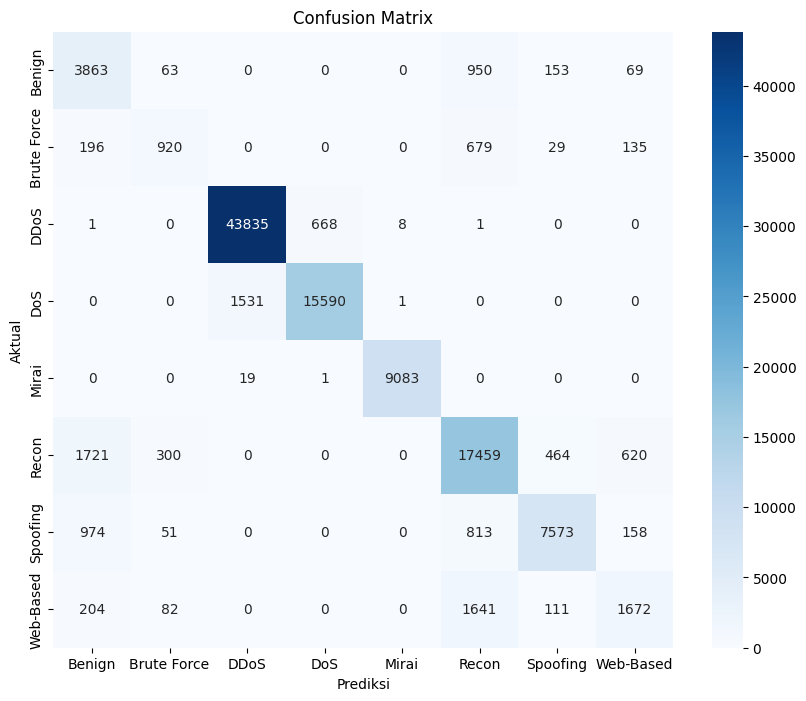

In [ ]:
# Confusion matrix
# Use y_test and y_final_pred from the previous cell
cm = confusion_matrix(y_test, y_final_pred)
class_labels = sorted(set(y_test))


print("\nConfusion Matrix:")
# Use y_test and y_final_pred and class_labels
conf_matrix = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_support = cm.sum(axis=1)

df_class_perf = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': class_accuracy,
    'Support': class_support,
    'Errors': class_support - cm.diagonal()
}).sort_values('Accuracy')

print("\n📉 WORST 10 Classes:")
print(df_class_perf.head(10).to_string(index=False))

print("\n📈 BEST 10 Classes:")
print(df_class_perf.tail(10).to_string(index=False))


📉 WORST 10 Classes:
      Class  Accuracy  Support  Errors
  Web-Based  0.450674     3710    2038
Brute Force  0.469627     1959    1039
     Benign  0.757748     5098    1235
   Spoofing  0.791410     9569    1996
      Recon  0.849008    20564    3105
        DoS  0.910524    17122    1532
       DDoS  0.984768    44513     678
      Mirai  0.997803     9103      20

📈 BEST 10 Classes:
      Class  Accuracy  Support  Errors
  Web-Based  0.450674     3710    2038
Brute Force  0.469627     1959    1039
     Benign  0.757748     5098    1235
   Spoofing  0.791410     9569    1996
      Recon  0.849008    20564    3105
        DoS  0.910524    17122    1532
       DDoS  0.984768    44513     678
      Mirai  0.997803     9103      20


In [ ]:
# Most confused pairs
print("Most Confused Class Pairs:")
confusion_pairs = []

for i in range(len(class_labels)):
    for j in range(i+1, len(class_labels)):
        total_conf = cm[i, j] + cm[j, i]
        if total_conf > 50:  # Significant confusion
            confusion_pairs.append({
                'Class_A': class_labels[i],
                'Class_B': class_labels[j],
                'Confusion': total_conf
            })

df_confusion = pd.DataFrame(confusion_pairs).sort_values('Confusion', ascending=False)
print(df_confusion.head(10).to_string(index=False))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Most Confused Class Pairs:
    Class_A     Class_B  Confusion
     Benign       Recon       2671
      Recon   Web-Based       2261
       DDoS         DoS       2199
      Recon    Spoofing       1277
     Benign    Spoofing       1127
Brute Force       Recon        979
     Benign   Web-Based        273
   Spoofing   Web-Based        269
     Benign Brute Force        259
Brute Force   Web-Based        217

📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.76      0.64      5098
 Brute Force       0.65      0.47      0.55      1959
        DDoS       0.97      0.98      0.98     44513
         DoS       0.96      0.91      0.93     17122
       Mirai       1.00      1.00      1.00      9103
       Recon       0.81      0.85      0.83     20564
    Spoofing       0.91      0.79      0.85      9569
   Web-Based       0.63      0.45      0.53      3710

    accuracy                           0.90    111638
   macro avg       0

In [ ]:
# Cek Ram Tersedia
ram_available = psutil.virtual_memory().available / 1024**2
print(f"\n💾 Available RAM: {ram_available:.2f} MB ({ram_available/1024:.2f} GB)")


💾 Available RAM: 7529.04 MB (7.35 GB)
